In [18]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.35

matplotlib.rcParams['xtick.major.size'] = 1.5  # length of major xticks
matplotlib.rcParams['xtick.major.width'] = 0.3   # width of major xticks
matplotlib.rcParams['ytick.major.size'] = 1.5  # length of major yticks
matplotlib.rcParams['ytick.major.width'] = 0.3   # width of major yticks


# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
import protfasta

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

from sparrow import Protein
from sparrow.data.amino_acids import VALID_AMINO_ACIDS

from finches import Mpipi_frontend
mf = Mpipi_frontend()

In [48]:
def compute_B2(residue_1, 
               residue_2, 
               r, 
               kB, 
               T, 
               salt=None, 
               use_volume_element_correction=True, 
               plot_potential=False):
    """
    Function which calculates the un-corrected B2. Note this has had no
    unit corrections so is a constant factor away from the true B2, so should ONLY
    be used for sanity checking.

    NOTE - this assumes there's a gloabl mPiPi_GGv1_model object that's been 
    initialized already.

    Parameters
    -----------------
    residue_1 : str
        Amino acid string for first residues 

    residue_2 : str
        Amino acid string for second residues 

    r : np.array
        1-D numpy array defining distance values over which potential should be 
        calculated.

    kB : float
        Boltzman factor; suggest setting to 1 for convenience... 

    T : float
        Temperature; suggest setting to 10 for convenience (units here arbitrary)

    salt : float {None}
        Salt concentration (in molar). By default uses the mPiPi_GGv1 model

    use_volume_element_correction : bool
        If set to true calculate B2 using standard equation. If false, we excluded
        the r^2 term.
    
    plot_potential : bool
        If set to True, plot the potential showing the area being integrated

    """

    # get the dielectric from the initialized 
    dielectric = mf.IMC_object.parameters.dielectric

    if salt == None:
        salt = mf.IMC_object.parameters.salt
    
    sig1 = mf.IMC_object.parameters.SIGMA_ALL[residue_1][residue_2]*1
    sig3 = mf.IMC_object.parameters.SIGMA_ALL[residue_1][residue_2]*3
        
    # get index in distance-dependent energy that matches 1 sigma
    s1 = np.argmin(abs(sig1 - np.array(r)))
    
    # get index of 3*sigma
    s3 = np.argmin(abs(sig3 - np.array(r)))
    
    # calculate the combined energy vector of the rage 
    combo = mf.IMC_object.parameters.compute_full_Mpipi(residue_1, residue_2, r, dielectric=dielectric, salt=salt)

    if plot_potential:
        ax = plt.gca()
        plt.plot(r,combo)
        plt.plot(r[s1:s3], combo[s1:s3], '--k')
        plt.ylim([-2,2])
        ax.axvline(sig1, ls='--', linewidth=0.5, color='k')
        ax.axvline(3*sig1, ls='--', linewidth=0.5, color='k')
        ax.axhline(0, ls='--', linewidth=0.5, color='k')
        plt.xlabel('r (A)')
        plt.ylabel('u(r) kj/mol')
        
    # take the numerical finite integral between 1 and 3 sigma to calculate
    # an interacion parameter
    interaction_param = np.trapz(combo[s1:s3], x=r[s1:s3])

    if use_volume_element_correction:
        B22 = 2*np.pi*np.trapz((1 - np.exp(-combo[s1:s3]/(kB*T)))*r[s1:s3]*r[s1:s3], x=r[s1:s3])
    else:        
        B22 = 2*np.pi*np.trapz((1 - np.exp(-combo[s1:s3]/(kB*T))), x=r[s1:s3])

    
    return interaction_param, B22

In [46]:
compute_B2(aa1, aa2, r, kB, T, use_volume_element_correction=False)

here


(-0.9440804322813608, -0.025805766788710403)

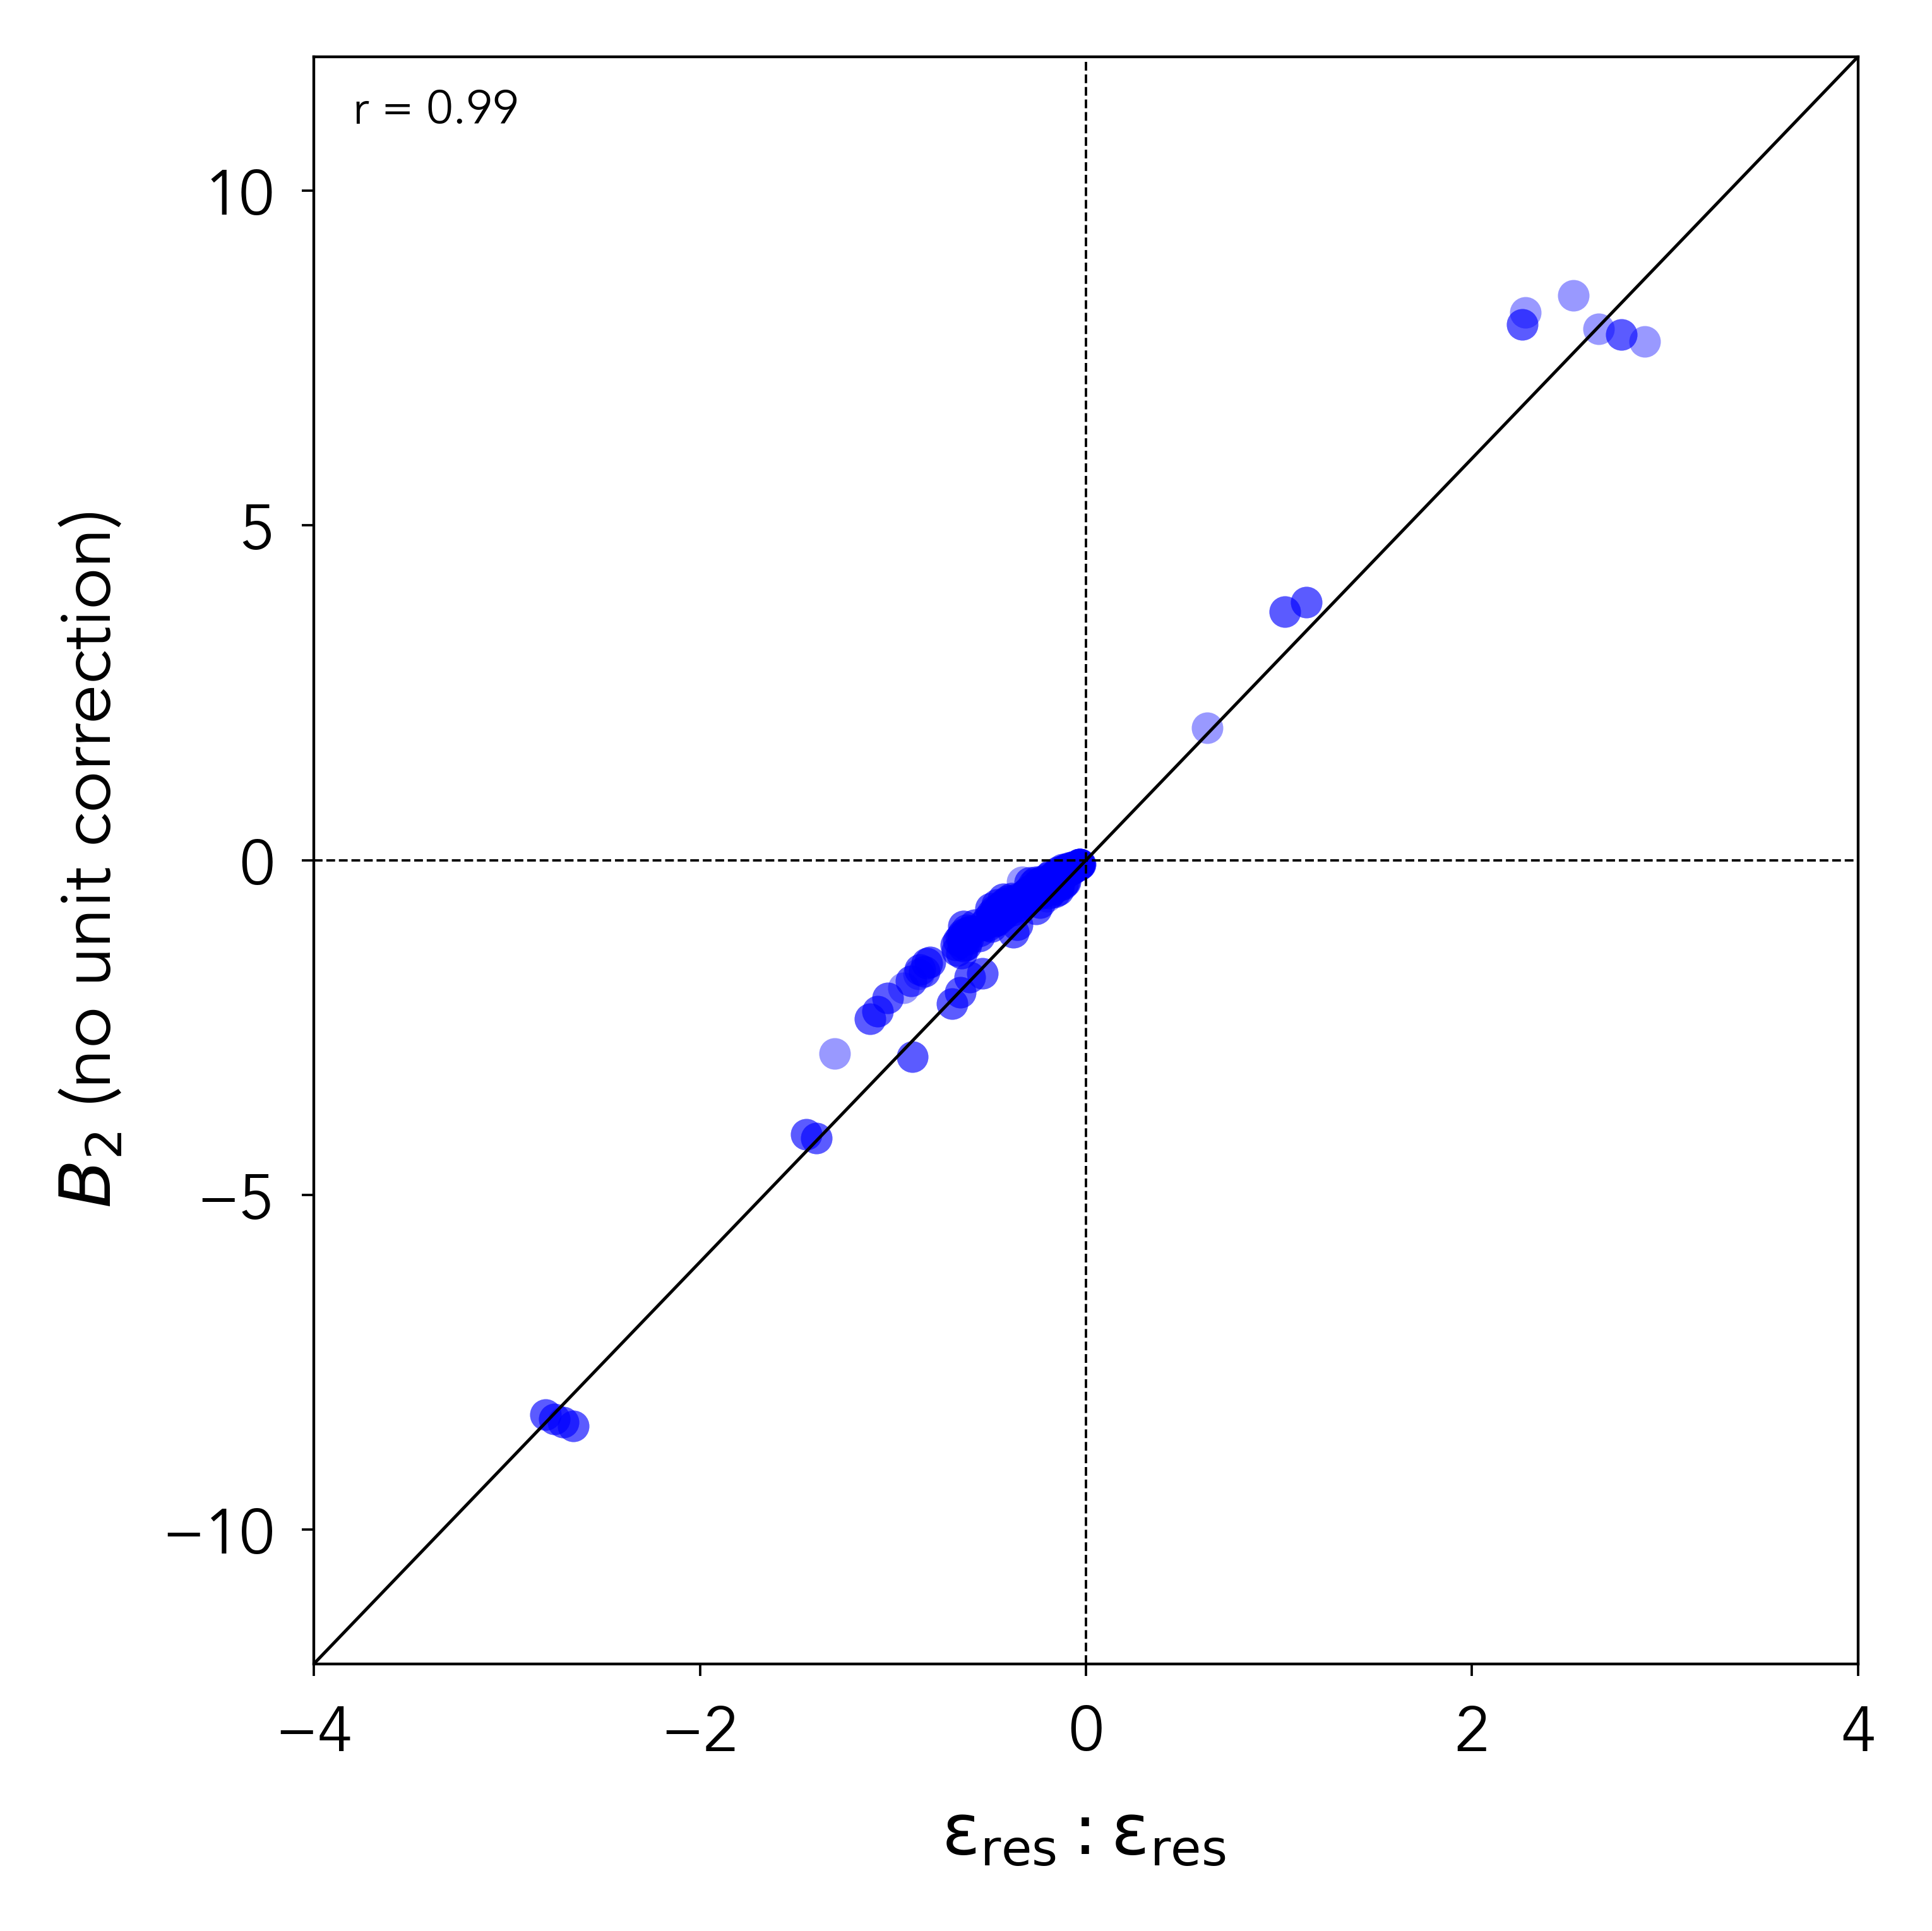

In [71]:
figure(None, (3.5,3.5), dpi=450)
ax = plt.gca()
all_b2s = []
all_ips = []
name = []
kB = 10
T = 23
r = np.arange(2,30,0.01)

for aa1 in VALID_AMINO_ACIDS:
    for aa2 in VALID_AMINO_ACIDS:

        v = compute_B2(aa1, aa2, r, kB, T)
        all_ips.append(v[0])
        all_b2s.append(v[1])
        name.append(f'{aa1}-{aa2}')

plt.plot(all_ips, all_b2s,'.b', ms=8, alpha=0.4,mew=0)
#plt.plot([0],[0],'ok', alpha=0.4,mew=0)
plt.plot([-4,4],[-12,12], color='k',linewidth=0.4)

plt.text(-3.8, 11, f"r = {np.round(np.corrcoef(all_ips,all_b2s)[0][1],2)}", fontsize=6)

ax.axhline(0, ls='--', color='k', lw=0.3)
ax.axvline(0, ls='--', color='k', lw=0.3)

plt.ylim([-12,12])
plt.xlim([-4,4])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel(r'$B_2$ (no unit correction)', fontsize=9)
plt.xlabel(r'$\rm \epsilon_{res}:\epsilon_{res}$ ', fontsize=9)

plt.tight_layout()
plt.savefig('out_figures/b2_vs_eps.pdf')

In [57]:
np.corrcoef(all_ips,all_b2s)

array([[1.       , 0.9999998],
       [0.9999998, 1.       ]])

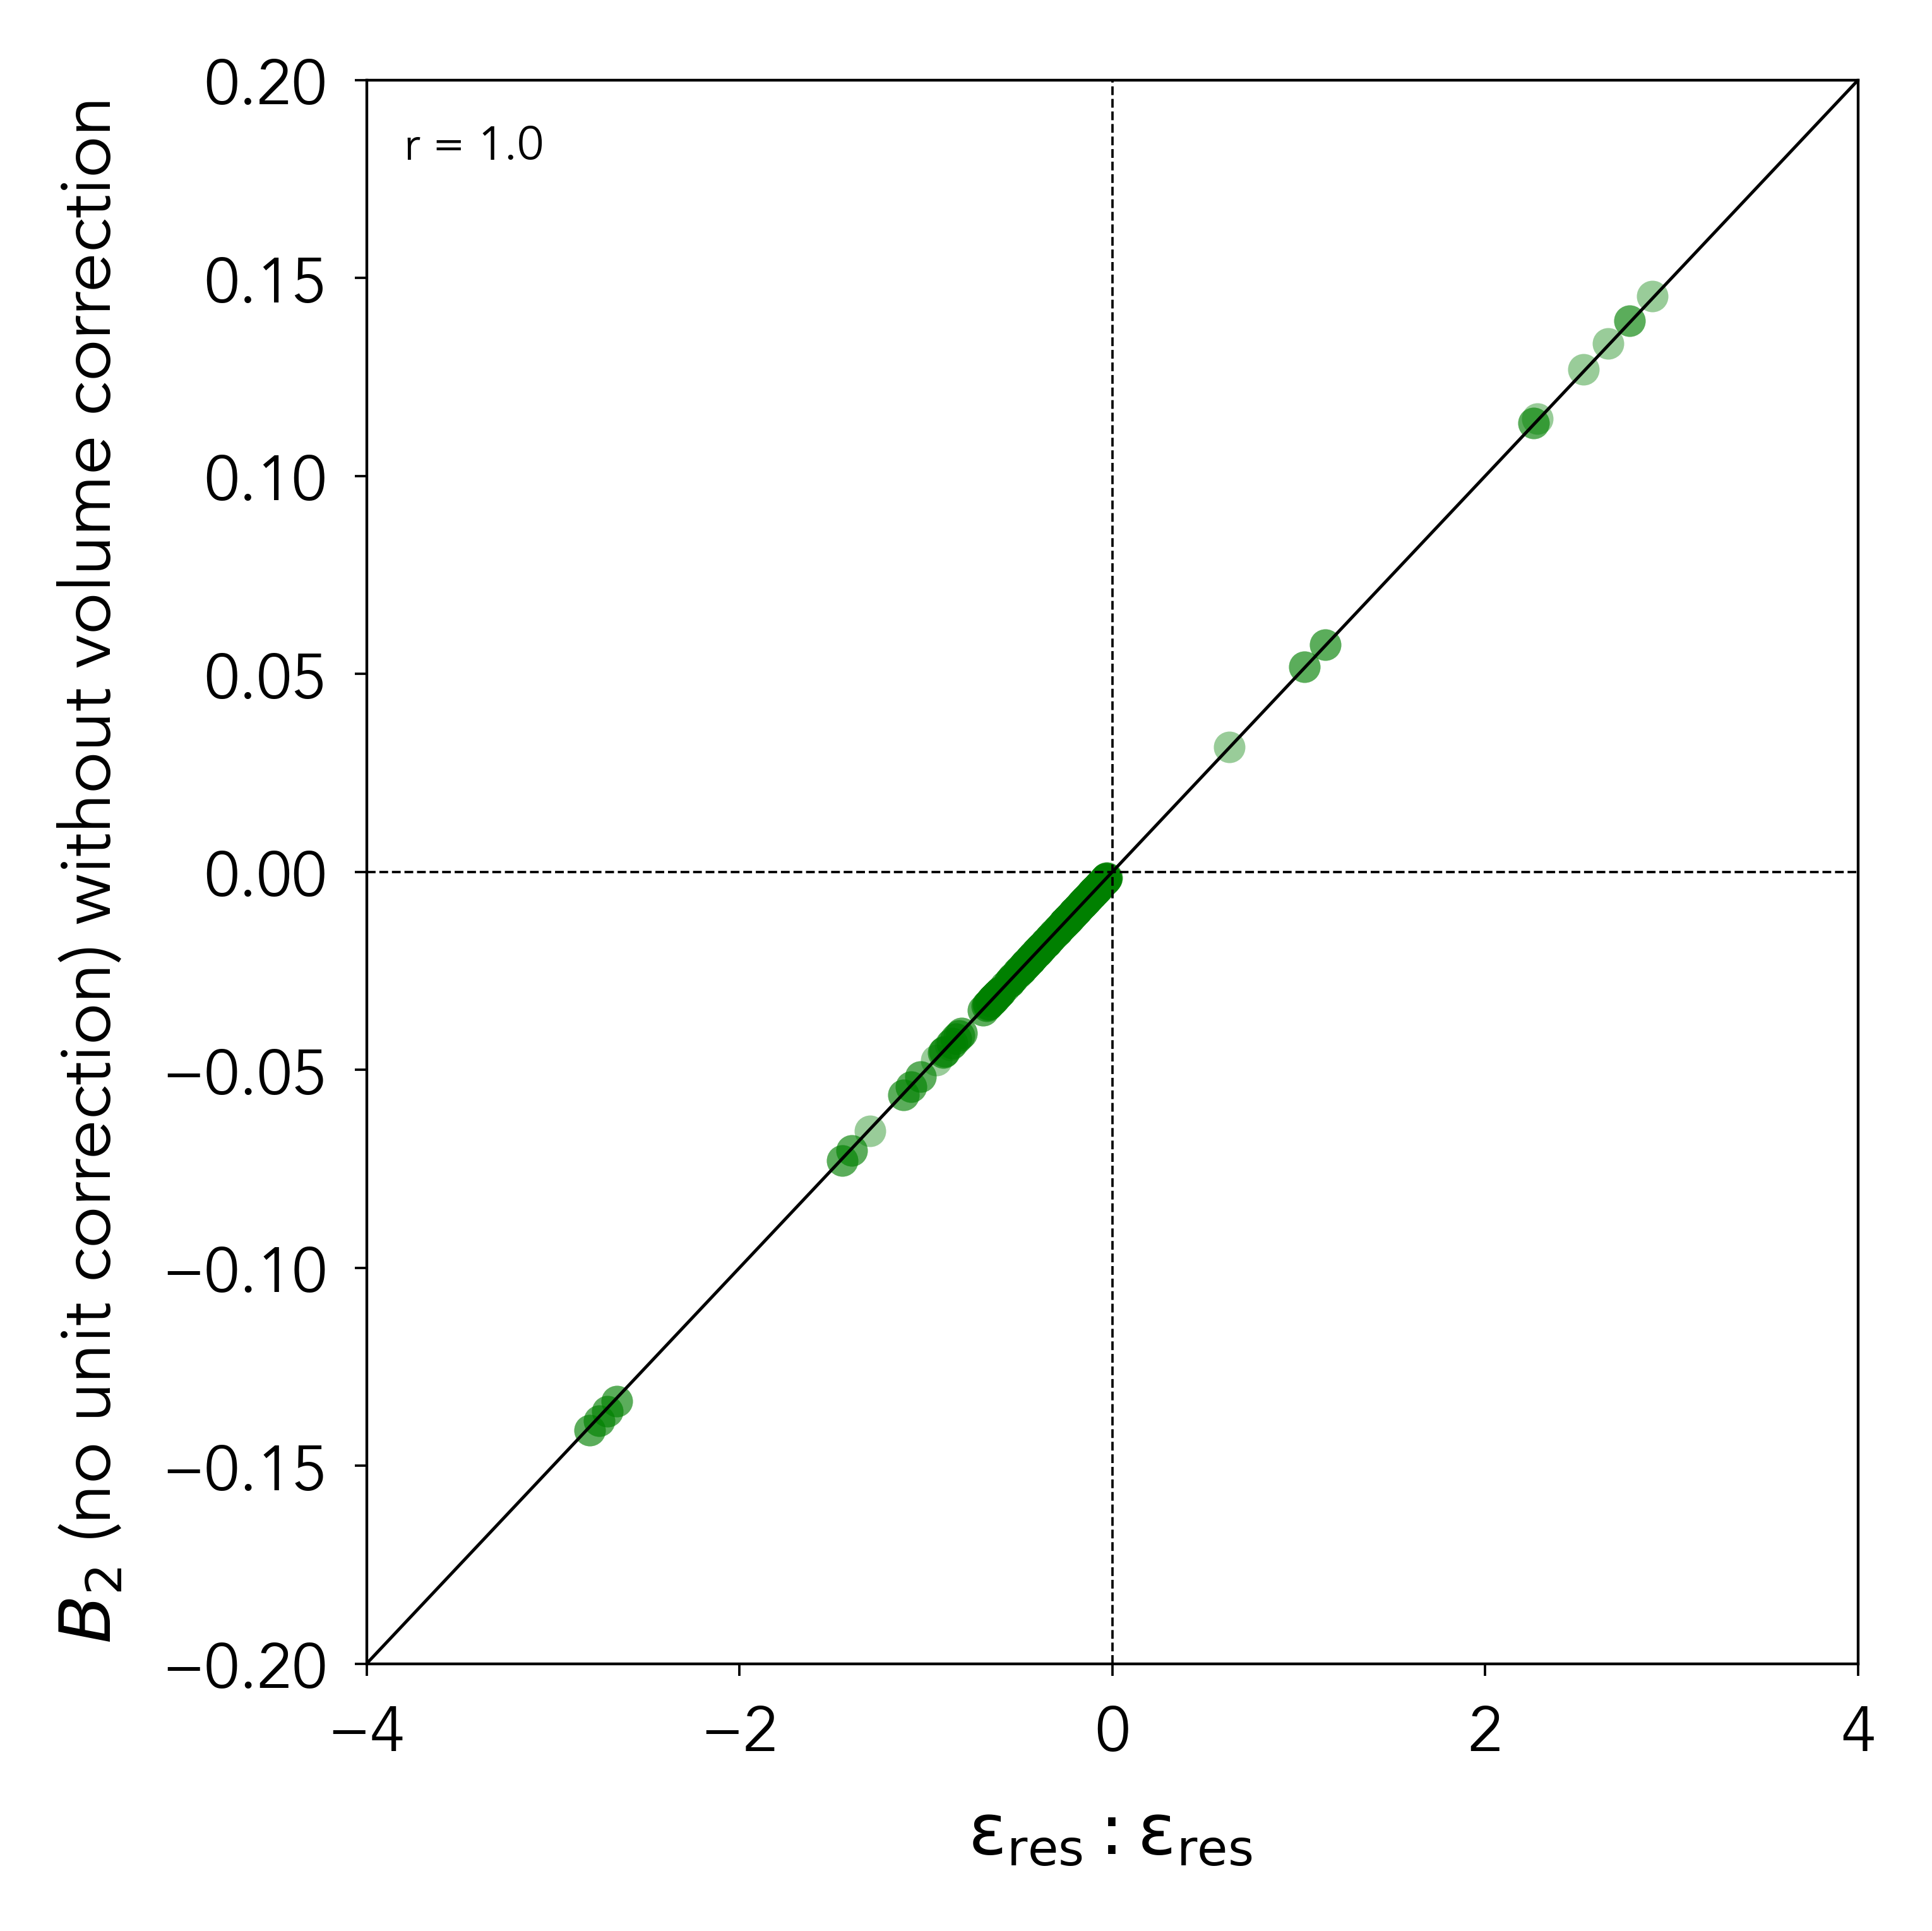

In [77]:
figure(None, (3.5,3.5), dpi=450)
ax = plt.gca()
all_b2s = []
all_ips = []
name = []
kB = 10
T = 12.5
r = np.arange(2,30,0.01)

for aa1 in VALID_AMINO_ACIDS:
    for aa2 in VALID_AMINO_ACIDS:

        v = compute_B2(aa1, aa2, r, kB, T, use_volume_element_correction=False)
        all_ips.append(v[0])
        all_b2s.append(v[1])
        name.append(f'{aa1}-{aa2}')

plt.plot(all_ips, all_b2s,'.', color='green', ms=8, alpha=0.4,mew=0)
plt.plot([-4,4],[-0.2,0.2], color='k',linewidth=0.4)
plt.text(-3.8, 0.18, f"r = {np.round(np.corrcoef(all_ips,all_b2s)[0][1],2)}", fontsize=6)

ax.axhline(0, ls='--', color='k', lw=0.3)
ax.axvline(0, ls='--', color='k', lw=0.3)

plt.ylim([-0.2,0.2])
plt.xlim([-4,4])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel(r'$B_2$ (no unit correction) without volume correction', fontsize=9)
plt.xlabel(r'$\rm \epsilon_{res}:\epsilon_{res}$ ', fontsize=9)
plt.tight_layout()
plt.savefig('out_figures/b2_vs_eps_nocorr.pdf')